In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm, colors, gridspec
import hsluv


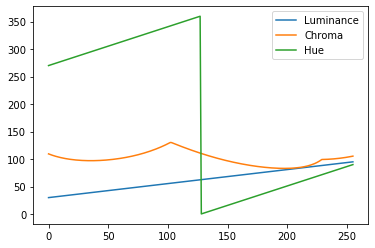

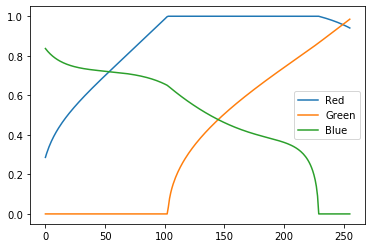

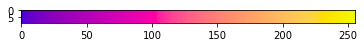

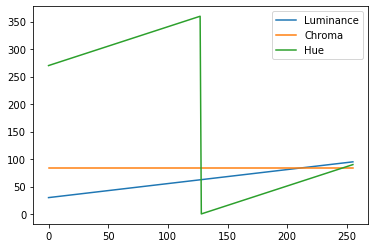

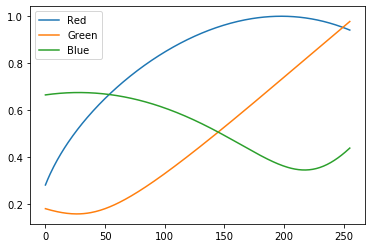

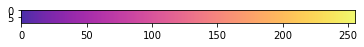

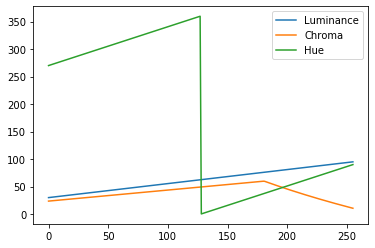

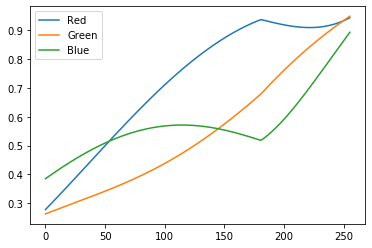

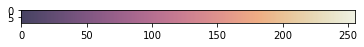

In [165]:
hsluv_arr = np.stack([np.linspace(270,450,256)[np.newaxis]%360, np.full((1,256), 100.), np.linspace(30,95,256)[np.newaxis]], -1).squeeze()
hsluv_rgb = np.stack([hsluv.hsluv_to_rgb(hsluv_arr[i].tolist()) for i in range(256)])
# plt.plot(hsluv_rgb)
# plt.legend(['Red', 'Green', 'Blue'])
lch = np.stack([hsluv.hsluv_to_lch(hsluv_arr[i].tolist()) for i in range(256)])
plt.plot(lch)
plt.legend(['Luminance', 'Chroma', 'Hue'])
hsluv_rgb = np.stack([hsluv.hsluv_to_rgb(hsluv_arr[i].tolist()) for i in range(256)])
plt.figure()
plt.plot(hsluv_rgb)
plt.legend(['Red', 'Green', 'Blue'])

plt.figure()
plt.imshow(np.stack([hsluv_rgb]*10,0))

lch[:,1] = np.min(lch[:,1])
lch_rgb = np.stack([hsluv.lch_to_rgb(lch[i].tolist()) for i in range(256)])
plt.figure()
plt.plot(lch)
plt.legend(['Luminance', 'Chroma', 'Hue'])

plt.figure()
plt.plot(lch_rgb)
plt.legend(['Red', 'Green', 'Blue'])
plt.figure()
plt.imshow(np.stack([lch_rgb]*10,0))
lch_cmap = colors.ListedColormap(lch_rgb)

lch_hp = np.stack([hsluv.hpluv_to_lch(hsluv_arr[i].tolist()) for i in range(256)])
plt.figure()
plt.plot(lch_hp)
plt.legend(['Luminance', 'Chroma', 'Hue'])

plt.figure()
hpluv_rgb = np.stack([hsluv.hpluv_to_rgb(hsluv_arr[i].tolist()) for i in range(256)])
plt.plot(hpluv_rgb)
plt.legend(['Red', 'Green', 'Blue'])

plt.figure()
plt.imshow(np.stack([hpluv_rgb]*10,0))
hpluv_cmap = colors.ListedColormap(hpluv_rgb)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


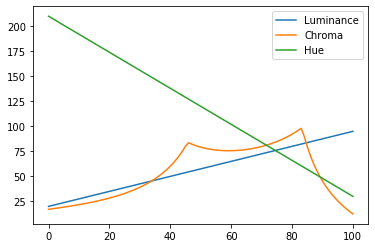

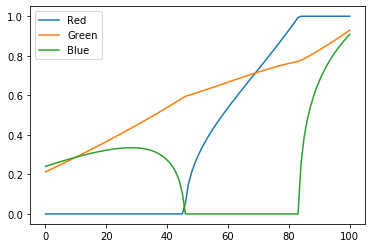

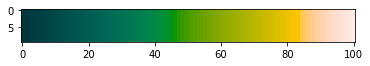

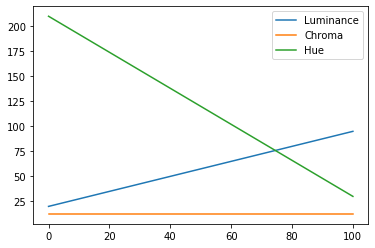

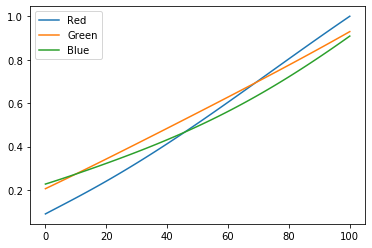

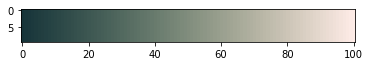

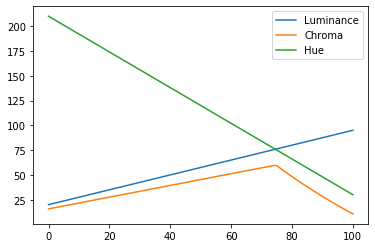

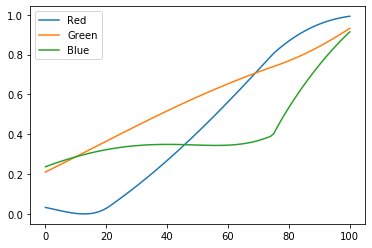

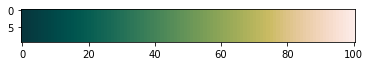

In [4]:
hsluv_arr = np.stack([np.linspace(210,30,101)[np.newaxis], np.full((1,101), 100.), np.linspace(20, 95, 101)[np.newaxis]], -1).squeeze()
hsluv_rgb = np.stack([hsluv.hsluv_to_rgb(hsluv_arr[i].tolist()) for i in range(101)])
# plt.plot(hsluv_rgb)
# plt.legend(['Red', 'Green', 'Blue'])
lch = np.stack([hsluv.hsluv_to_lch(hsluv_arr[i].tolist()) for i in range(101)])
plt.plot(lch)
plt.legend(['Luminance', 'Chroma', 'Hue'])
hsluv_rgb = np.stack([hsluv.hsluv_to_rgb(hsluv_arr[i].tolist()) for i in range(101)])
plt.figure()
plt.plot(hsluv_rgb)
plt.legend(['Red', 'Green', 'Blue'])

plt.figure()
plt.imshow(np.stack([hsluv_rgb]*10,0))

lch[:,1] = np.min(lch[:,1])
lch_rgb = np.stack([hsluv.lch_to_rgb(lch[i].tolist()) for i in range(101)])
plt.figure()
plt.plot(lch)
plt.legend(['Luminance', 'Chroma', 'Hue'])

plt.figure()
plt.plot(lch_rgb)
plt.legend(['Red', 'Green', 'Blue'])
plt.figure()
plt.imshow(np.stack([lch_rgb]*10,0))

lch_hp = np.stack([hsluv.hpluv_to_lch(hsluv_arr[i].tolist()) for i in range(101)])
plt.figure()
plt.plot(lch_hp)
plt.legend(['Luminance', 'Chroma', 'Hue'])

plt.figure()
hpluv_rgb = np.stack([hsluv.hpluv_to_rgb(hsluv_arr[i].tolist()) for i in range(101)])
plt.plot(hpluv_rgb)
plt.legend(['Red', 'Green', 'Blue'])

plt.figure()
plt.imshow(np.stack([hpluv_rgb]*10,0))

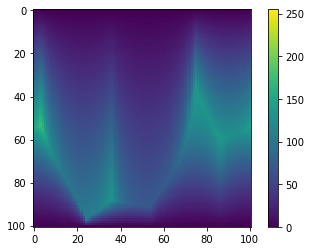

In [11]:
chroma_space = np.zeros((101,101))
for j in range(101):
    hsluv_arr = np.stack([np.linspace(0,360-360/101,101)[np.newaxis], np.full((1,101), 100.), np.full((1,101), j)], -1).squeeze()
    lch = np.stack([hsluv.hsluv_to_lch(hsluv_arr[i].tolist()) for i in range(101)])
    chroma_space[j] = lch[:,1]
plt.imshow(chroma_space,vmin=0,vmax=255)
plt.colorbar()

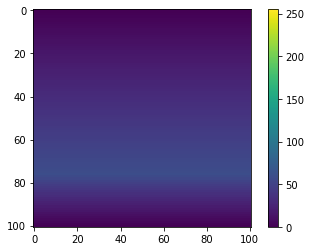

In [12]:
chroma_space_hp = np.zeros((101,101))
for j in range(101):
    hsluv_arr = np.stack([np.linspace(0,360,101)[np.newaxis], np.full((1,101), 100.), np.full((1,101), j)], -1).squeeze()
    lch = np.stack([hsluv.hpluv_to_lch(hsluv_arr[i].tolist()) for i in range(101)])
    chroma_space_hp[j] = lch[:,1]
plt.imshow(chroma_space_hp,vmin=0,vmax=255)
plt.colorbar()

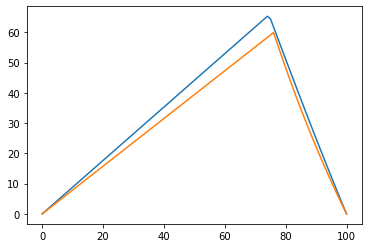

In [13]:
plt.plot(np.min(chroma_space[:,60:90],1))
plt.plot(np.min(chroma_space_hp,1))

In [360]:
def lab_to_lch(lab):
    c = (lab[1]**2 + lab[2]**2)**0.5
    h = 0 if (lab[1] == 0) and (lab[2] == 0) else np.degrees(np.arctan2(lab[2], lab[1])) % 360
    lch = (lab[0], c, h%360)
    return lch

def lch_to_lab(lch):
    c = lch[1]
    h = np.radians(lch[2])
    a = c * np.cos(h)
    b = c * np.sin(h)
#     a = (c**2 / (1 + np.tan(h)**2))**0.5
#     b = (c**2 / (1 + (1 / np.tan(h)**2)))**0.5
    lab = (lch[0], a, b)
    return lab

def lab_to_rgb(lab):
    return hsluv.lch_to_rgb(lab_to_lch(lab))

def cie_diff(rgb1, rgb2):
    lch1 = hsluv.rgb_to_lch(rgb1)
    lab1 = lch_to_lab(lch1)
    lch2 = hsluv.rgb_to_lch(rgb2)
    lab2 = lch_to_lab(lch2)
    
    dL = lab2[0]-lab1[0]
    L_mean = (lab1[0] + lab2[0]) / 2
    
    C_mean = (lch1[1] + lch2[1]) / 2
    
    C_factor = (C_mean**7 / (C_mean**7 + 25**7))**0.5
    
    a1 = lab1[1] * (1 + 0.5*(1 - C_factor))
    a2 = lab2[1] * (1 + 0.5*(1 - C_factor))
    
    C1 = (a1**2 + lab1[2]**2)**0.5
    C2 = (a2**2 + lab2[2]**2)**0.5
    
    Cp_mean = (C1 + C2) / 2
    dC = C2 - C1
    
    h1 = np.degrees(np.arctan2(lab1[2], a1)) % 360
    h2 = np.degrees(np.arctan2(lab2[2], a2)) % 360
    
    dh = h2 - h1
    if abs(dh)<=180:
        dh = np.radians(dh)
        H_mean = np.radians((h1 + h2) / 2)
    else:
        if lch2[2]<=lch1[2]:
            dh = np.radians(dh+360)
        else:
            dh = np.radians(dh-360)
        if (h1 - h2) < 360:
            H_mean = np.radians((h1 + h2 + 360) / 2)
        else:
            H_mean = np.radians((h1 + h2 - 360) / 2)
    dH = 2 * (C1 * C2)**0.5 * np.sin(dh/2)
    
    T = 1 - 0.17*np.cos(H_mean - np.radians(30)) \
          + 0.24*np.cos(2*H_mean) \
          + 0.32*np.cos(3*H_mean + np.radians(6)) \
          - 0.2*np.cos(4*H_mean - np.radians(63))
    Sl = 1 + 0.015*(L_mean-50)**2/(20+(L_mean-50)**2)**0.5
    Sc = 1 + 0.045*Cp_mean
    Sh = 1 + 0.015*Cp_mean*T
    Rt = -2 * (Cp_mean**7 / (Cp_mean**7 + 25**7))**0.5 * np.sin(np.radians(60 * np.exp(-((np.degrees(H_mean) - 275) / 25)**2)))
    dE = ((dL/Sl)**2 + (dC/Sc)**2 + (dH/Sh)**2 + Rt*(dC/Sc)*(dH/Sh))**0.5
    return dE

In [359]:
cie_diff(hsluv.lch_to_rgb(lab_to_lch((50, 2.6772, -79.7751))), hsluv.lch_to_rgb(lab_to_lch((50, 0, -82.7485))))

2.0424596801564125

In [363]:
L1 = [50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,60.2574,63.0109,61.2901,35.0831,22.7233,36.4612,90.8027,90.9257,6.7747,2.0776]
a1 = [2.6772,3.1571,2.8361,-1.3802,-1.1848,-0.9009,0.0000,-1.0000,2.4900,2.4900,2.4900,2.4900,-0.0010,-0.0010,-0.0010,2.5000,2.5000,2.5000,2.5000,2.5000,2.5000,2.5000,2.5000,2.5000,-34.0099,-31.0961,3.7196,-44.1164,20.0904,47.8580,-2.0831,-0.5406,-0.2908,0.0795]
b1 = [-79.7751,-77.2803,-74.0200,-84.2814,-84.8006,-85.5211,0.0000,2.0000,-0.0010,-0.0010,-0.0010,-0.0010,2.4900,2.4900,2.4900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,36.2677,-5.8663,-5.3901,3.7933,-46.6940,18.3852,1.4410,-0.9208,-2.4247,-1.1350]

L2 = [50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,50.0000,73.0000,61.0000,56.0000,58.0000,50.0000,50.0000,50.0000,50.0000,60.4626,62.8187,61.4292,35.0232,23.0331,36.2715,91.1528,88.6381,5.8714,0.9033]
a2 = [0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,0.0000,-2.4900,-2.4900,-2.4900,-2.4900,0.0009,0.0010,0.0011,0.0000,25.0000,-5.0000,-27.0000,24.0000,3.1736,3.2972,1.8634,3.2592,-34.1751,-29.7946,2.2480,-40.0716,14.9730,50.5065,-1.6435,-0.8985,-0.0985,-0.0636]
b2 = [-82.7485,-82.7485,-82.7485,-82.7485,-82.7485,-82.7485,2.0000,0.0000,0.0009,0.0010,0.0011,0.0012,-2.4900,-2.4900,-2.4900,-2.5000,-18.0000,29.0000,-3.0000,15.0000,0.5854,0.0000,0.5757,0.3350,39.4387,-4.0864,-4.9620,1.5901,-42.5619,21.2231,0.0447,-0.7239,-2.2286,-0.5514]

diffs = [cie_diff(lab_to_rgb((L1[i], a1[i], b1[i])), lab_to_rgb((L2[i], a2[i], b2[i])))
         for i in range(len(L1))]

In [364]:
diffs

[2.0424596801564125,
 2.8615101747473233,
 3.441190598690549,
 0.9999988647523939,
 1.0000047010742752,
 1.0000129676235554,
 2.3668588191756927,
 2.3668588191756927,
 7.179172011348769,
 7.219470093152632,
 7.219472152285456,
 7.2194742124711775,
 4.804521685774806,
 4.8045245082118235,
 4.746071113806707,
 4.306482095827405,
 27.14923130074688,
 22.897692469805385,
 31.90300464686006,
 19.45352143339341,
 1.000026343370323,
 0.9999728729731475,
 1.000049498977304,
 1.0000347617152814,
 1.2644200135991106,
 1.2629592982621933,
 1.8730705001186263,
 1.8644952341594458,
 2.0372582697089316,
 1.414577922493855,
 1.4441290780927827,
 1.5381170054396105,
 0.6377276718841319,
 0.9082328396025035]

In [365]:
def plot_cm_diff(colormap):
    diffs = [cie_diff(colormap(i+1/255)[:3], colormap(i)[:3]) for i in np.arange(0,1,1/255)]
    ax1 = plt.subplot(2,1,1)
    ax1.plot(diffs)
    ax2 = plt.subplot(2,1,2, sharex=ax1)
    ax2.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

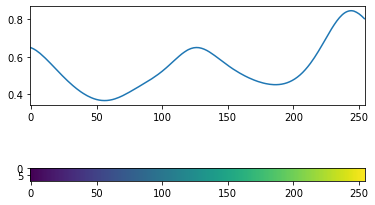

In [366]:
plot_cm_diff(cm.viridis)

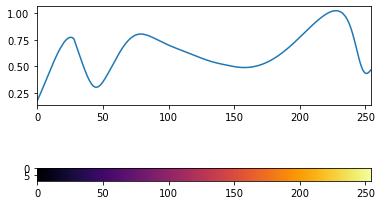

In [367]:
plot_cm_diff(cm.inferno)

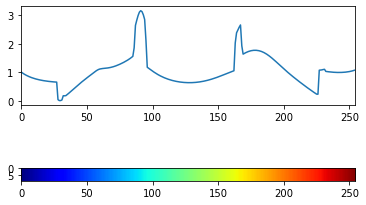

In [368]:
plot_cm_diff(cm.jet)

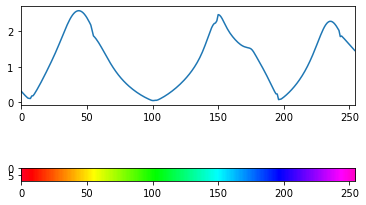

In [369]:
plot_cm_diff(cm.gist_rainbow)

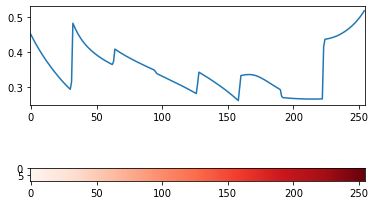

In [370]:
plot_cm_diff(cm.Reds)

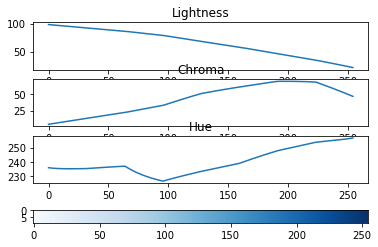

In [371]:
colormap = cm.Blues
lch = np.array([hsluv.rgb_to_lch(colormap(i)[:3]) for i in np.arange(0,1,1/255)])
plt.subplot(4,1,1)
plt.plot(lch[:,0])
plt.title('Lightness')
plt.subplot(4,1,2)
plt.plot(lch[:,1])
plt.title('Chroma')
plt.subplot(4,1,3)
plt.plot(lch[:,2])
plt.title('Hue')
plt.subplot(4,1,4)
plt.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

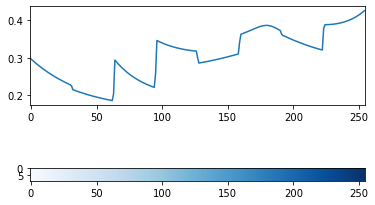

In [372]:
plot_cm_diff(cm.Blues)

In [378]:
cie_diff(hsluv.hsluv_to_rgb((240,100,57.864)), hsluv.hsluv_to_rgb((240,100,20)))

36.096739473760344

In [379]:
cie_diff(hsluv.hsluv_to_rgb((240,100,57.864)), hsluv.hsluv_to_rgb((240,100,100)))

40.679652105289854

In [380]:
la, lb = 20,100
ma, mb = 100, 100
sm1 = 100
sm2 = 50
lm = (lb+la)/2
diff_a, diff_b = cie_diff(hsluv.hsluv_to_rgb((240,sm1,lm)), hsluv.hsluv_to_rgb((240,ma,la))), \
                 cie_diff(hsluv.hsluv_to_rgb((240,sm1,lm)), hsluv.hsluv_to_rgb((240,mb,lb)))
diff_ratio1 = diff_a/(diff_a+diff_b)
print(diff_ratio1)
diff_a, diff_b = cie_diff(hsluv.hsluv_to_rgb((240,sm2,lm)), hsluv.hsluv_to_rgb((240,ma,la))), \
                 cie_diff(hsluv.hsluv_to_rgb((240,sm2,lm)), hsluv.hsluv_to_rgb((240,mb,lb)))
diff_ratio2 = diff_a/(diff_a+diff_b)
print(diff_ratio2)


0.4925349037899685
0.5027987681638005


In [321]:
ds = (sm1*diff_ratio2-sm2*diff_ratio1)/(diff_ratio1-diff_ratio2)
ds

56.77977911428837

In [322]:
la, lb = 20,100
ma, mb = 100, 100
sm1 = 100
sm2 = ds
lm = (lb+la)/2
diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,sm1,lm)), hsluv.hsluv_to_lch((240,ma,la))), \
                 cie_diff(hsluv.hsluv_to_lch((240,sm1,lm)), hsluv.hsluv_to_lch((240,mb,lb)))
diff_ratio1 = diff_a/(diff_a+diff_b)
print(diff_ratio1)
diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,sm2,lm)), hsluv.hsluv_to_lch((240,ma,la))), \
                 cie_diff(hsluv.hsluv_to_lch((240,sm2,lm)), hsluv.hsluv_to_lch((240,mb,lb)))
diff_ratio2 = diff_a/(diff_a+diff_b)
print(diff_ratio2)


0.5265182802903967
0.39752412373829804


In [277]:
la, lb = 20,100
lm = (lb+la)/2
diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,la))), \
                 cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,lb)))

for i in range(1000):
    diff_ratio = diff_a/(diff_a+diff_b)
    lm = lb - (lb-lm)*2*diff_ratio
    diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,la))), \
                     cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,lb)))
    if abs(diff_ratio-0.5) < 0.000001:
        print(i)
        break

print(diff_a, diff_b)
print(lm)

15
9.28630391423226 9.286291255025533
53.83180628560204


In [213]:
la, lb = 20,53.83180628560204
lm = (lb+la)/2
diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,la))), \
                 cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,lb)))

for i in range(1000):
    diff_ratio = diff_a/(diff_a+diff_b)
    lm = lb - (lb-lm)*2*diff_ratio
    diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,la))), \
                     cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,lb)))
    if abs(diff_ratio-0.5) < 0.000001:
        print(i)
        break

print(diff_a, diff_b)
print(lm)

6
4.650237130598562 4.650236835437467
40.31516833870883


In [214]:
la, lb = 53.83180628560204, 100
lm = (lb+la)/2
diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,la))), \
                 cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,lb)))

for i in range(1000):
    diff_ratio = diff_a/(diff_a+diff_b)
    lm = lb - (lb-lm)*2*diff_ratio
    diff_a, diff_b = cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,la))), \
                     cie_diff(hsluv.hsluv_to_lch((240,100,lm)), hsluv.hsluv_to_lch((240,100,lb)))
    if abs(diff_ratio-0.5) < 0.000001:
        print(i)
        break

print(diff_a, diff_b)
print(lm)

24
4.665112810651963 4.66512205976454
81.8271079162218


In [222]:
a = [0,1]
a[1:]= [0, 0.5]
a

[0, 0, 0.5]

In [236]:
def recursive_insert(a,b,levels):
    ab = (a+b)/2
    if levels > 1:
        return recursive_insert(a, ab, levels-1) + recursive_insert(ab, b, levels-1)[1:]
    else:
        return [a, ab, b]

In [238]:
len(recursive_insert(0,1,8))

257

In [389]:
def recursive_differ(h,s,la,lb,levels):
    lm = (lb+la)/2
    diff_a, diff_b = cie_diff(hsluv.hsluv_to_rgb((h,s,lm)), hsluv.hsluv_to_rgb((h,s,la))), \
                     cie_diff(hsluv.hsluv_to_rgb((h,s,lm)), hsluv.hsluv_to_rgb((h,s,lb)))

    for i in range(20):
        diff_ratio = diff_a/(diff_a+diff_b)
        lm = lb - (lb-lm)*2*diff_ratio
        diff_a, diff_b = cie_diff(hsluv.hsluv_to_rgb((h,s,lm)), hsluv.hsluv_to_rgb((h,s,la))), \
                         cie_diff(hsluv.hsluv_to_rgb((h,s,lm)), hsluv.hsluv_to_rgb((h,s,lb)))
        if abs(diff_ratio-0.5) < 0.000001:
            break
    if levels > 1:
        return recursive_differ(h,s,la,lm,levels-1) + recursive_differ(h,s,lm,lb,levels-1)[1:]
    else:
        return [la,lm,lb]

In [390]:
h, s = 240, 100
ls = recursive_differ(h,s,100,20,8)
rgbs = [hsluv.hsluv_to_rgb((h,s,l)) for l in ls]

In [391]:
len(rgbs)

257

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


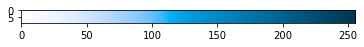

In [392]:
plt.imshow(np.stack([rgbs[:-1]]*10,0))

In [393]:
np.minimum(np.maximum(rgbs[:-1],0),1)

array([[1.        , 1.        , 1.        ],
       [0.99766129, 0.99869911, 1.        ],
       [0.99528382, 0.9973785 , 1.        ],
       [0.99286699, 0.99603794, 1.        ],
       [0.9904102 , 0.99467721, 1.        ],
       [0.98791285, 0.99329606, 1.        ],
       [0.9853743 , 0.99189426, 1.        ],
       [0.98279393, 0.99047159, 1.        ],
       [0.98017109, 0.9890278 , 1.        ],
       [0.97750525, 0.98756271, 1.        ],
       [0.97479561, 0.98607604, 1.        ],
       [0.9720415 , 0.98456753, 1.        ],
       [0.96924221, 0.98303694, 1.        ],
       [0.96639705, 0.98148403, 1.        ],
       [0.96350526, 0.97990854, 1.        ],
       [0.96056611, 0.97831022, 1.        ],
       [0.95757881, 0.97668881, 1.        ],
       [0.95454398, 0.97504481, 1.        ],
       [0.95145945, 0.9733772 , 1.        ],
       [0.94832438, 0.97168573, 1.        ],
       [0.94513791, 0.96997011, 1.        ],
       [0.94189917, 0.96823008, 1.        ],
       [0.

In [394]:
test_cm = colors.ListedColormap(np.minimum(np.maximum(rgbs[:-1],0),1))


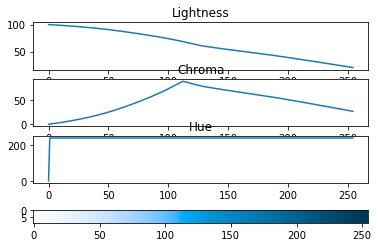

In [395]:
colormap = test_cm
lch = np.array([hsluv.rgb_to_lch(colormap(i)[:3]) for i in np.arange(0,1,1/255)])
plt.subplot(4,1,1)
plt.plot(lch[:,0])
plt.title('Lightness')
plt.subplot(4,1,2)
plt.plot(lch[:,1])
plt.title('Chroma')
plt.subplot(4,1,3)
plt.plot(lch[:,2])
plt.title('Hue')
plt.subplot(4,1,4)
plt.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

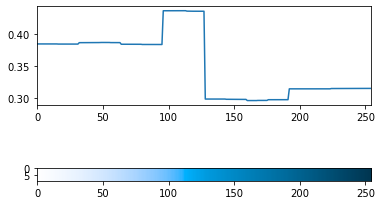

In [396]:
plot_cm_diff(test_cm)

In [427]:
hsl_blues = colors.ListedColormap(np.minimum(np.maximum(
    [hsluv.hsluv_to_rgb(ct) for ct in zip(np.full(256,230), np.full(256, 100), np.linspace(20,100,256))],0),1))

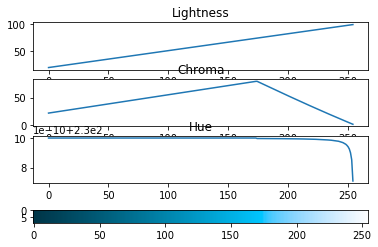

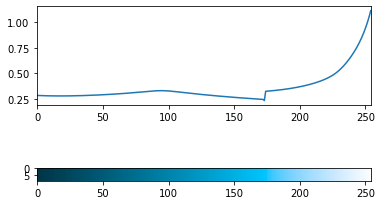

In [428]:
colormap = hsl_blues
lch = np.array([hsluv.rgb_to_lch(colormap(i)[:3]) for i in np.arange(0,1,1/255)])
plt.subplot(4,1,1)
plt.plot(lch[:,0])
plt.title('Lightness')
plt.subplot(4,1,2)
plt.plot(lch[:,1])
plt.title('Chroma')
plt.subplot(4,1,3)
plt.plot(lch[:,2])
plt.title('Hue')
plt.subplot(4,1,4)
plt.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))
plt.figure()
plot_cm_diff(hsl_blues)

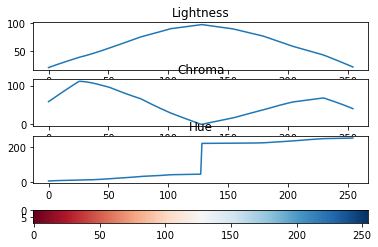

In [422]:
colormap = cm.RdBu
lch = np.array([hsluv.rgb_to_lch(colormap(i)[:3]) for i in np.arange(0,1,1/255)])
plt.subplot(4,1,1)
plt.plot(lch[:,0])
plt.title('Lightness')
plt.subplot(4,1,2)
plt.plot(lch[:,1])
plt.title('Chroma')
plt.subplot(4,1,3)
plt.plot(lch[:,2])
plt.title('Hue')
plt.subplot(4,1,4)
plt.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

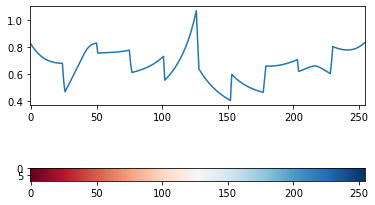

In [185]:
plot_cm_diff(cm.RdBu)

In [86]:
def lab_to_lch(lab):
    c = (lab[1]**2+lab[2]**2)**0.5
    h = 0 if (lab[1]==0) and (lab[2]==0) else np.degrees(np.arctan2(lab[2],lab[1]))
    lch = (lab[0], c, h%360)
    return lch

In [87]:
lab_to_lch((50,2.6772,-79.7751))

(50, 79.82000989632863, 271.9220874035611)

In [73]:
hsluv.lch_to_rgb(lab_to_lch((50,2.6772,-79.7751)))

[0.7717076870685572, 0.30505515157930474, 0.4368776978117778]

In [88]:
cie_diff(lab_to_lch((50,2.6772,-79.7751)), lab_to_lch((50,0.,-82.7485)))

0.5027170483301338

In [95]:
cie_diff(hsluv.lch_to_rgb((50.,79.82,271.9222)),hsluv.lch_to_rgb((50.,82.7485,270.0000)))

0.8346197193026088

In [156]:
pdb.runcall(cie_diff,hsluv.lch_to_rgb((50.,77.3448,272.3395)),hsluv.lch_to_rgb((50.,82.7485,270.)))

> <ipython-input-109-58913d3071d9>(2)cie_diff()
-> lch1 = hsluv.rgb_to_lch(rgb1)
(Pdb) Sc
*** NameError: name 'Sc' is not defined
(Pdb) r
--Return--
> <ipython-input-109-58913d3071d9>(29)cie_diff()->2.8614663327936363
-> return dE
(Pdb) Sc
4.602099249999981
(Pdb) Sh
1.8216132222440584
(Pdb) T
0.684278665206737
(Pdb) Rt
-1.7069997550988079
(Pdb) dC/Sc
1.174181543346794
(Pdb) dE
2.8614663327936363
(Pdb) q


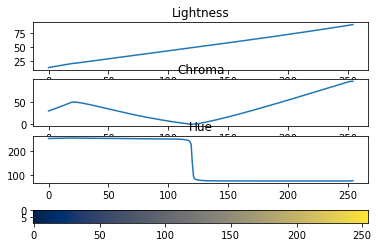

In [418]:
colormap = cm.cividis
lch = np.array([hsluv.rgb_to_lch(colormap(i)[:3]) for i in np.arange(0,1,1/255)])
plt.subplot(4,1,1)
plt.plot(lch[:,0])
plt.title('Lightness')
plt.subplot(4,1,2)
plt.plot(lch[:,1])
plt.title('Chroma')
plt.subplot(4,1,3)
plt.plot(lch[:,2])
plt.title('Hue')
plt.subplot(4,1,4)
plt.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

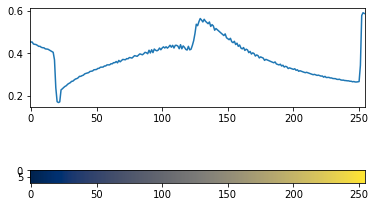

In [419]:
plot_cm_diff(cm.cividis)

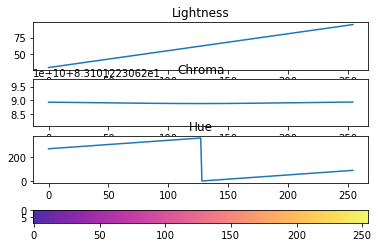

In [168]:
colormap = lch_cmap
lch = np.array([hsluv.rgb_to_lch(colormap(i)[:3]) for i in np.arange(0,1,1/255)])
plt.subplot(4,1,1)
plt.plot(lch[:,0])
plt.title('Lightness')
plt.subplot(4,1,2)
plt.plot(lch[:,1])
plt.title('Chroma')
plt.subplot(4,1,3)
plt.plot(lch[:,2])
plt.title('Hue')
plt.subplot(4,1,4)
plt.imshow(np.stack([colormap(np.arange(0,1,1/255))]*10,0))

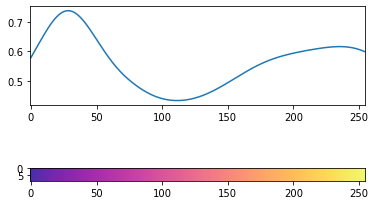

In [171]:
plot_cm_diff(lch_cmap)

In [172]:
np.mean([cie_diff(colormap(i+1/255)[:3], colormap(i)[:3]) for i in np.arange(0,1,1/255)])

0.5630554020929369

In [179]:
mean_diffs = [np.mean([cie_diff(colormap(i+(j+1)/255)[:3], colormap(i)[:3]) for i in np.arange(0,1,1/255)[:-j]])/(j+1) for j in range(255)]

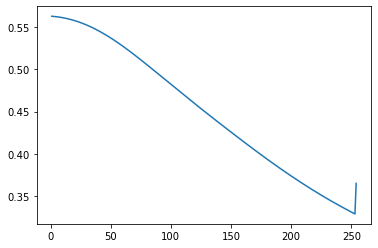

In [180]:
plt.plot(mean_diffs)

In [149]:
cie_diff(hsluv.lch_to_rgb((50.,77.3448,272.3395)),
         hsluv.lch_to_rgb((50.,82.7485,270.)))

2.8614663327936363

In [127]:
cie_diff(hsluv.lch_to_rgb((50.,74.0743,272.1944)),
         hsluv.lch_to_rgb((50.,82.7485,270.0000)))

3.441183320019691

In [128]:
cie_diff(hsluv.lch_to_rgb((50.,84.2927,269.0618)),
         hsluv.lch_to_rgb((50.,82.7485,270.0000)))

0.999963410944035

In [129]:
cie_diff(hsluv.lch_to_rgb((50.,84.8089,269.1995)),
         hsluv.lch_to_rgb((50.,82.7485,270.0000)))

1.000006464800137

In [130]:
cie_diff(hsluv.lch_to_rgb((50.,85.5258,269.3964)),
         hsluv.lch_to_rgb((50.,82.7485,270.0000)))

1.000020984266833

In [131]:
cie_diff(hsluv.lch_to_rgb((50.,0.,0.)),
         hsluv.lch_to_rgb((50.,2.5000,126.8697)))

2.3668639053281275

In [132]:
cie_diff(hsluv.lch_to_rgb((50.,2.5000,126.8697)),
         hsluv.lch_to_rgb((50.,0.,0.)))

2.3668639053281275

In [133]:
cie_diff(hsluv.lch_to_rgb((50.,3.7346,359.9847)),
         hsluv.lch_to_rgb((50.,3.7346,179.9862)))

7.179150323512359

In [135]:
cie_diff(hsluv.lch_to_rgb((50.,2.4900,90.0345)),
         hsluv.lch_to_rgb((50.,2.4900,270.0311)))

4.8045209465345495

In [136]:
cie_diff(hsluv.lch_to_rgb((50.,3.4569,0.0000)),
         hsluv.lch_to_rgb((73.,38.9743,332.4939)))

27.149216911780996

In [137]:
cie_diff(hsluv.lch_to_rgb((50.,3.4569,0.0000)),
         hsluv.lch_to_rgb((61.,29.8307,103.5532)))

22.872492118611913

In [138]:
pdb.runcall(cie_diff,hsluv.lch_to_rgb((50.,3.4569,0.0000)),
         hsluv.lch_to_rgb((61.,29.8307,103.5532)))

> <ipython-input-109-58913d3071d9>(2)cie_diff()
-> lch1 = hsluv.rgb_to_lch(rgb1)
(Pdb) r
--Return--
> <ipython-input-109-58913d3071d9>(29)cie_diff()->22.872492118611913
-> return dE
(Pdb) T
0.6447489070191005
(Pdb) Sl
1.0640101146391678
(Pdb) Sc
1.748970999999972
(Pdb) Sh
1.1609660778796616
(Pdb) Rt
-1.1638538484803985e-35
(Pdb) lch1
[50.000000000000014, 3.4568999999977907, 5.9803886226173965e-12]
(Pdb) lch2
[60.999999999999986, 29.830700000000963, 103.55320000000413]
(Pdb) Cm
16.643799999999377
(Pdb) hm
*** NameError: name 'hm' is not defined
(Pdb) Hm
0.9036721454881842
(Pdb) np.degrees(hm)
*** NameError: name 'hm' is not defined
(Pdb) np.degrees(Hm)
51.776600000005054
(Pdb) Cm
16.643799999999377
(Pdb) lch[1]+lch2[1]
array([ 45.12593318,  67.61494063, 323.08544374])
(Pdb) (lch1[1]+lch2[1])/2
16.643799999999377
(Pdb) q
